# CS342 Final Project
### Dayou Ren; Spencer Petty
### dr37269; sap3758

In this project, we will be building and training an autoencoder architecture to generate images of CS professor. We are basically asking this question: "what does a neural network believe a CS professor should look like?"

In [1]:
import cv2
from PIL import Image
import numpy as np
import torchvision
import pickle

In [4]:
# Define the desired dimensions for the cropped and resized images
crop_size = (500, 500)

# Open each headshot image and crop it to the desired size
for i in range(1, 6):
    # Replace 'image_path' with the actual file path of the image
    image_path = f'./CS_prof_images/image_{i}.jpg'
    img = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect all the faces in the image
    faces = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml").detectMultiScale(gray, scaleFactor=1.3, minNeighbors=3)

    # Crop the image based on the location of the first detected face
    if len(faces) > 0:
        x, y, w, h = faces[0]
        face_image = gray[y:y+h, x:x+w]

        # Resize the cropped image to the desired dimensions
        resized_img = cv2.resize(face_image, crop_size)

        # Convert the resized image to RGB
        rgb_resized_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)

        # Save the resized image with the original file name
        output_path = f'./cropped_CS_prof_images/resized_image_{i}.jpg'
        Image.fromarray(rgb_resized_img).save(output_path)
    else:
        print(f"No face detected in image {i}. Skipping.")


In [2]:
crop_size = (500,500)

In [13]:
crop_size = (500, 500)

# Open each headshot image and crop it to the desired size
for i in range(1, 13234):
    # Replace 'image_path' with the actual file path of the image
    image_path = f'./lfw/image_{i}.jpg'
    img = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect all the faces in the image
    faces = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml").detectMultiScale(gray, scaleFactor=1.3, minNeighbors=3)

    # Crop the image based on the location of the first detected face
    if len(faces) > 0:
        x, y, w, h = faces[0]
        face_image = gray[y:y+h, x:x+w]

        # Resize the cropped image to the desired dimensions
        resized_img = cv2.resize(face_image, crop_size)

        # Convert the resized image to RGB
        rgb_resized_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)

        # Save the resized image with the original file name
        output_path = f'./cropped_lfw/resized_image_{i}.jpg'
        Image.fromarray(rgb_resized_img).save(output_path)
    else:
        print(f"No face detected in image {i}. Skipping.")

No face detected in image 22. Skipping.
No face detected in image 53. Skipping.
No face detected in image 63. Skipping.
No face detected in image 93. Skipping.
No face detected in image 177. Skipping.
No face detected in image 191. Skipping.
No face detected in image 212. Skipping.
No face detected in image 262. Skipping.
No face detected in image 326. Skipping.
No face detected in image 334. Skipping.
No face detected in image 386. Skipping.
No face detected in image 543. Skipping.
No face detected in image 567. Skipping.
No face detected in image 607. Skipping.
No face detected in image 622. Skipping.
No face detected in image 624. Skipping.
No face detected in image 625. Skipping.
No face detected in image 630. Skipping.
No face detected in image 635. Skipping.
No face detected in image 638. Skipping.
No face detected in image 650. Skipping.
No face detected in image 654. Skipping.
No face detected in image 674. Skipping.
No face detected in image 684. Skipping.
No face detected in 

No face detected in image 6788. Skipping.
No face detected in image 6866. Skipping.
No face detected in image 6868. Skipping.
No face detected in image 6872. Skipping.
No face detected in image 6877. Skipping.
No face detected in image 6917. Skipping.
No face detected in image 6967. Skipping.
No face detected in image 6976. Skipping.
No face detected in image 7059. Skipping.
No face detected in image 7090. Skipping.
No face detected in image 7115. Skipping.
No face detected in image 7126. Skipping.
No face detected in image 7215. Skipping.
No face detected in image 7236. Skipping.
No face detected in image 7304. Skipping.
No face detected in image 7350. Skipping.
No face detected in image 7392. Skipping.
No face detected in image 7422. Skipping.
No face detected in image 7431. Skipping.
No face detected in image 7453. Skipping.
No face detected in image 7462. Skipping.
No face detected in image 7501. Skipping.
No face detected in image 7599. Skipping.
No face detected in image 7610. Sk

No face detected in image 13114. Skipping.
No face detected in image 13118. Skipping.
No face detected in image 13120. Skipping.
No face detected in image 13121. Skipping.
No face detected in image 13178. Skipping.


# Variational Autoencoder Class

In [3]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import numpy as np
import matplotlib.pyplot as plt


In [4]:
image_size = crop_size[0] * crop_size[1] * 3

class VAE(nn.Module):
    def __init__(self, latent_dims, hidden_nodes):
        super().__init__()
        self.encode1 = torch.nn.Linear(in_features = image_size, out_features = hidden_nodes)
        self.encode_mu = torch.nn.Linear(hidden_nodes, latent_dims)
        self.encode_sigma = torch.nn.Linear(hidden_nodes, latent_dims)
        self.N = torch.distributions.Normal(0, 1)
        self.kl = 0

        self.decode1 = torch.nn.Linear(latent_dims, hidden_nodes)
        self.decode2 = torch.nn.Linear(hidden_nodes, image_size)

    def forward(self, x):
        relu = torch.nn.ReLU()
        sigmoid = torch.nn.Sigmoid()
        # Encoding
        x = torch.flatten(x, start_dim = 1)
        x = self.encode1(x)
        x = relu(x)
        # Variational part of VAE
        mu = self.encode_mu(x)
        sigma = torch.exp(self.encode_sigma(x))
        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()

        #Decoding
        z = self.decode1(z)
        z = relu(z)
        z = self.decode2(z)
        x_hat = sigmoid(z)

        return torch.reshape(x_hat, (-1, 3, crop_size[0], crop_size[1]))

In [5]:
# Test the syntax and dimensionality of the model on a few samples. Expect noise as output
def test_noise_generation():
    model = VAE(10, 256)
    i = np.random.choice(13234)
    image_path = f'./cropped_lfw/Faces/image_{i}.jpg'
    imgnp = cv2.imread(image_path)
    img = torch.reshape(torch.tensor(imgnp, dtype = torch.float32), (1, -1, crop_size[0], crop_size[1]))
    out = model(img)
    plt.imshow(imgnp)
    plt.matshow(out.squeeze().detach().reshape((crop_size[0], crop_size[1], -1)))

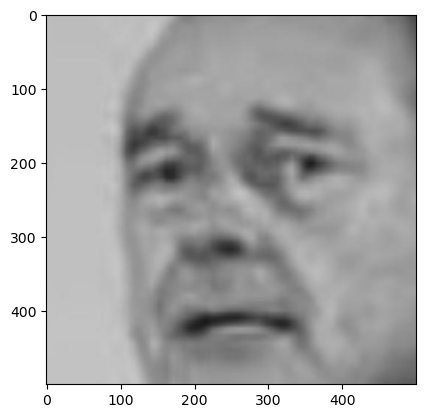

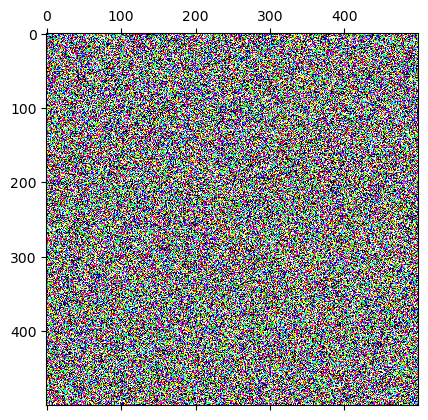

In [6]:
test_noise_generation()

In [7]:
def vae_loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x.view(-1, image_size), x.view(-1, image_size), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


dataset = torchvision.datasets.ImageFolder('./cropped_lfw', transform=torchvision.transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

model = VAE(10, 256)
# Doing in-place allows easier saving via pickle
def train_vae(model, dataloader, nepochs=100):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(nepochs):
        train_loss = 0
        for batch_idx, (data, _) in enumerate(dataloader):
            optimizer.zero_grad()
            x_hat = model(data)
            loss = ((data - x_hat)**2).mean() + model.kl
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            
            if batch_idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(dataloader.dataset),
                    100. * batch_idx / len(dataloader),
                    loss.item() / len(data)))

        print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(dataloader.dataset)))
                
            
train_vae(model, dataloader, nepochs = 1)

Train Epoch: 0 [0/12845 (0%)]	Loss: 5.652251


KeyboardInterrupt: 

In [ ]:
# Saves the model
pickle.dump(model, open('model.pkl', 'wb'))